### (DISCONTINUED) Resting State EEG: data visualisation

In [2]:
import pandas as pd
import os

os.chdir('/Users/tanijarv/Documents/GitHub/EEG-pyline')

import basic.arrange_data as arrange
from basic.stats import apply_stat_test
import data_visualisation as dataviz

In [2]:
"""
VARIABLES TO CHANGE
psd_{xxx}_folder: A relative folder location of the regional/channels/asymmetry PSD files
exp_folder: A relative folder location of the comparable experiments as a list of strings
condition_code_list: A list of compared experiments' short codes (reference to exp_condition from 02-notebook)
stat_test: The name of the statistical test to be used
"""
psd_reg_folder = r"Results/LABS-LEISURE/Absolute PSD/regions"
psd_ch_folder = r"Results/LABS-LEISURE/Absolute PSD/channels"
psd_faa_folder = r"Results/LABS-LEISURE/Absolute PSD"
psd_fooof_folder = r"Results/LABS-LEISURE/FOOOF"
condition_legend = ['LABS','LEISURE']
stat_test = 'Wilcoxon'
#non_responders = "OKTOS_0003|OKTOS_0008|OKTOS_0011|OKTOS_0012|OKTOS_0025|OKTOS_0026|OKTOS_0027|OKTOS_0040"

exp_folder_ec = [r"Eyes Closed/LABS",r"Eyes Closed/LEISURE"]
condition_codes_ec = ['EC_LABS','EC_LEISURE']
condition_codes_comparisons_ec = [['EC_LABS','EC_LEISURE']]

# exp_folder_eo = [r"Eyes Open\Baseline",
#                  r"Eyes Open\6 weeks",
#                  r"Eyes Open\10 weeks"]
# condition_codes_eo = ['EO_00','EO_06','EO_07']
# condition_codes_comparisons_eo = [['EO_00','EO_06'],['EO_06','EO_07'],['EO_00','EO_07']]

In [7]:
print('Eyes closed')
[df_psd_reg_ec,df_psd_ch_ec,df_faa_ec,epochs_ec] = arrange.read_group_psd_data(psd_reg_folder,psd_ch_folder,psd_faa_folder,
                                                    exp_folder_ec,non_responders=None,data_folder='Data/Clean/LABS-LEISURE/')
# export_group_psd_comparison(psd_reg_folder,psd_ch_folder,df_psd_reg_ec,df_psd_ch_ec,stat_test,
#                             condition_codes_comparisons_ec,verbose=True)

# FOOOF merge two groups together!!!
# Locate all PSD files (regions, channels and asymmetry) and save their information
dir_inprogress_fooof,b_names_fooof,condition_fooof = [None]*len(exp_folder_ec),[None]*len(exp_folder_ec),[None]*len(exp_folder_ec)
for i in range(len(exp_folder_ec)):
    [dir_inprogress_fooof[i],b_names_fooof[i],condition_fooof[i]] = arrange.read_excel_psd(exp_folder_ec[i],psd_fooof_folder,verbose=False)


# Read all REGIONAL spectral data and save to dataframe
df_psd_fooof = pd.DataFrame()
for i in range(len(b_names_fooof[0])):
    for n_exps in range(len(b_names_fooof)):
        globals()[b_names_fooof[n_exps][i]] = pd.read_excel('{}/{}.xlsx'\
                                            .format(dir_inprogress_fooof[n_exps],b_names_fooof[n_exps][i]))\
        .assign(**{'Frequency band':'FOOOF','Condition': condition_fooof[n_exps][i][0]})
        df_psd_fooof = pd.concat([df_psd_fooof,globals()[b_names_fooof[n_exps][i]]])

df_psd_fooof['Condition'] = df_psd_fooof['Condition'].str.replace("EC_","").str.replace("_fooof","")
df_psd_fooof[['Condition', 'Region']] = df_psd_fooof['Condition'].str.split('_', 1, expand=True)
df_psd_fooof = df_psd_fooof.rename(columns={'Unnamed: 0': 'Subject'})

df_psd_fooof_frontal = df_psd_fooof[df_psd_fooof['Region']=='Frontal']
df_psd_fooof_parietal = df_psd_fooof[df_psd_fooof['Region']=='Parietal']

df_psd_fooof_frontal = df_psd_fooof_frontal[['Subject','Exponent','Offset','Frequency band','Condition']]
df_psd_fooof_parietal = df_psd_fooof_parietal[['Subject','Exponent','Offset','Frequency band','Condition']]

Eyes closed


/var/folders/jg/fnt2pd_d7pv2l_8rzjtw0bcw5xtq8_/T/ipykernel_12006/3949149694.py:24: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df_psd_fooof[['Condition', 'Region']] = df_psd_fooof['Condition'].str.split('_', 1, expand=True)


In [ ]:
#clinical_data_path = r'C:\Users\TANIJARV\Downloads\Ketamine-SI project\eeg-pipeline\Data\clinicaldata.xlsx'
clinical_data_path = r'C:\Users\TANIJARV\Downloads\Ketamine-SI project\eeg-pipeline\Data\clinicaldata_wbiochem.xlsx'

# Read clinical outcomes data and add it to the PSD data
df_psd_reg_withclinical_ec = arrange.add_clinical_data_to_psd(df_psd_reg_ec,clinical_data_path,rstrip='_EC')
# df_psd_reg_withclinical_eo = arrange.add_clinical_data_to_psd(df_psd_reg_eo,clinical_data_path,rstrip='_EO')

# Create comparison dataframe for PSD and clinical outcomes data applying comparison pairs
df_psd_withclinical_comparison_ec = arrange.apply_comparison_pairs_to_data(df_psd_reg_withclinical_ec,
                                                                   condition_codes_comparisons_ec)
# df_psd_withclinical_comparison_eo = arrange.apply_comparison_pairs_to_data(df_psd_reg_withclinical_eo,
#                                                                    condition_codes_comparisons_eo)
                                                                   
# Merge the dataframes of the two states (EC, EO) together
df_psd_withclinical_comparison_ec['State'] = 'Eyes closed'
# df_psd_withclinical_comparison_eo['State'] = 'Eyes open'
df_psd_clinical_comparison = df_psd_withclinical_comparison_ec #pd.concat([df_psd_withclinical_comparison_ec,df_psd_withclinical_comparison_eo])
df_psd_clinical_comparison['Condition'] = df_psd_clinical_comparison['Condition']\
                                                .str.replace(r'EC_', '')#.str.replace(r'EO_', '')

# Remove subjects with missing data
df_psd_clinical_comparison = df_psd_clinical_comparison.dropna()

In [ ]:
display(df_psd_clinical_comparison)

**Plotting part**

Correlation scatter plot example

In [ ]:
dataviz.plot_correlation(df_psd_clinical_comparison,band='Theta',comparison_cond=['00','06'],region='Occipital',
                  clinical_outcome='ET-1',state=['Eyes closed','Eyes open'],
                  labels=['ET-1 (%)','Theta power at occipital region (%)'],correlation='Spearman',
                  fnt=['sans-serif',9,8],color_palette=["#008080","#ff0000"],title=False,
                  trend_line_ci=[True,None],legend=True,export=False)


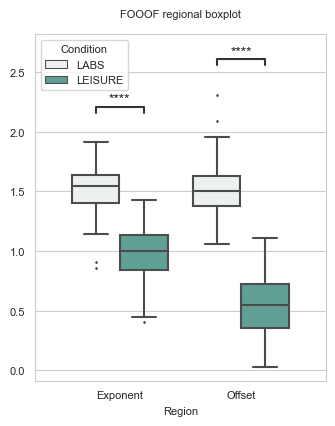

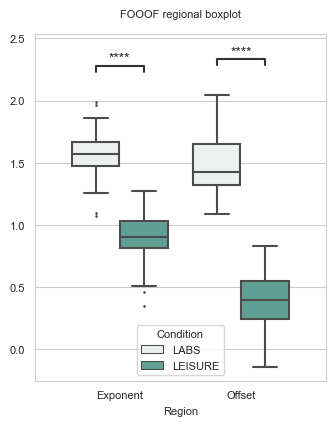

In [10]:
dataviz.plot_boxplot_band(df_psd_fooof_frontal,regions=['Exponent','Offset'],band='FOOOF',
                      condition_comp_list=[['LABS','LEISURE']],figsize=(3.75,4.5),yscale='linear',
                      condition_legend=condition_legend,fnt=['sans-serif',8,8],palette="light:#5A9",ylabel='',
                      legend=True,title=True,stat_test='t-test_ind',ast_loc='inside',verbose=False,export=False)
dataviz.plot_boxplot_band(df_psd_fooof_parietal,regions=['Exponent','Offset'],band='FOOOF',
                      condition_comp_list=[['LABS','LEISURE']],figsize=(3.75,4.5),yscale='linear',
                      condition_legend=condition_legend,fnt=['sans-serif',8,8],palette="light:#5A9",ylabel='',
                      legend=True,title=True,stat_test='t-test_ind',ast_loc='inside',verbose=False,export=False)

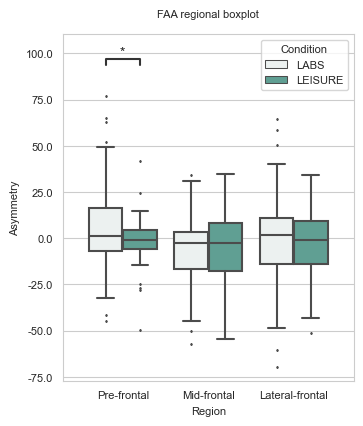

In [11]:
dataviz.plot_boxplot_band(df_faa_ec,regions=['Pre-frontal','Mid-frontal','Lateral-frontal'],band='FAA',
                      condition_comp_list=condition_codes_comparisons_ec,figsize=(3.75,4.5),yscale='linear',
                      condition_legend=condition_legend,fnt=['sans-serif',8,8],palette="light:#5A9",ylabel='Asymmetry',
                      legend=True,title=True,stat_test='t-test_ind',ast_loc='inside',verbose=False,export=False)

Boxplots and topomaps for displaying power spectra

t-test_ind: ['EC_LABS', 'EC_LEISURE'] Delta significant at ['Frontal' 'Parietal']
t-test_ind: ['EC_LABS', 'EC_LEISURE'] Beta significant at ['Frontal' 'Parietal']
t-test_ind: ['EC_LABS', 'EC_LEISURE'] Theta significant at ['Frontal' 'Parietal']
t-test_ind: ['EC_LABS', 'EC_LEISURE'] Alpha significant at ['Frontal' 'Parietal']


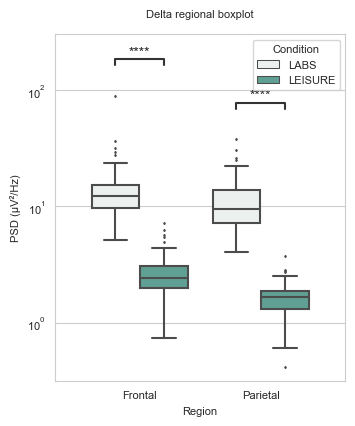

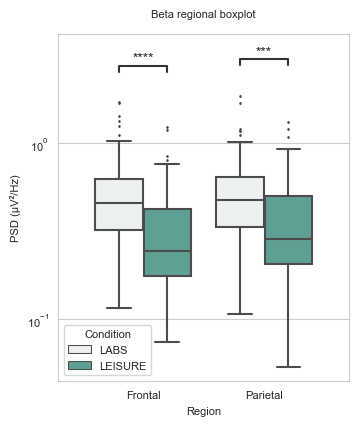

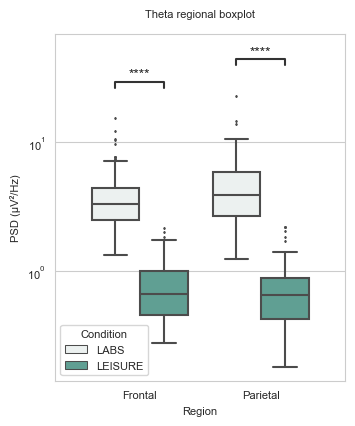

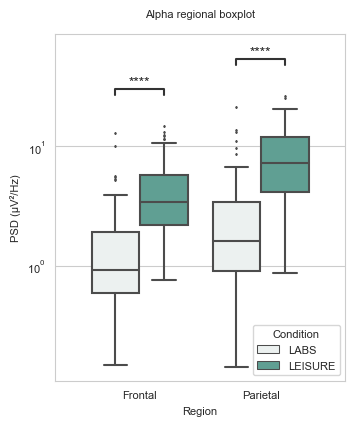

In [12]:
for b_name in (df_psd_reg_ec['Frequency band'].unique()):
    dataviz.plot_boxplot_band(df_psd_reg_ec,regions=['Frontal','Parietal'],band=b_name,
                      condition_comp_list=condition_codes_comparisons_ec,figsize=(3.75,4.5),yscale='log',
                      condition_legend=condition_legend,fnt=['sans-serif',8,8],palette="light:#5A9",
                      legend=True,title=True,stat_test='t-test_ind',ast_loc='inside',verbose=True,export=False)